In [2]:
! pip install -q -U git+https://github.com/google-research/dinosaur

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import functools
import jax
import dinosaur
import numpy as np
import matplotlib.pyplot as plt
import xarray

units = dinosaur.scales.units

def dimensionalize(x: xarray.DataArray, unit: units.Unit) -> xarray.DataArray:
  """Dimensionalizes `xarray.DataArray`s."""
  dimensionalize = functools.partial(physics_specs.dimensionalize, unit=unit)
  return xarray.apply_ufunc(dimensionalize, x)

# Held-Suarez Forcing Test

This notebook uses Dinosaur to run Held-Suarez integration test[1]. In this test a heuristic forcing terms are added to the primitive equations to produce steady state solution. The goal is to reconstruct statistics of the equilibrium state.

The notebook is split into 3 parts:
1. We unroll a trajectory only using primitive equations to verify that no interesting steady state is reached on its own.
2. We inspect implementation of the Held-Suarez test forcing terms.
3. We run simulation with forcing terms added to the equation.

We recommend using GPU runtime for this notebook. By default the notebook uses T42 spherical harmonic grid and 24 model levels, but higher resolution settings (e.g. T85 and 32 model levels can be used for higher-resolution results)

[1]  Held, I. M., and M. J. Suarez, 1994: "A proposal for the intercomparison of
  the dynamical cores of atmospheric general circulation models."
  Bulletin of the American Meteorological Society, 75, 1825–1830.

## Settings

In [4]:
# Resolution

units = dinosaur.scales.units
layers = 24
coords = dinosaur.coordinate_systems.CoordinateSystem(
    horizontal=dinosaur.spherical_harmonic.Grid.T42(),
    vertical=dinosaur.sigma_coordinates.SigmaCoordinates.equidistant(layers))
physics_specs = dinosaur.primitive_equations.PrimitiveEquationsSpecs.from_si()

p0 = 100e3 * units.pascal
p1 = 5e3 * units.pascal
rng_key = jax.random.PRNGKey(0)

## Isothermal Rest Atmosphere

In [5]:
# Smooth Planet (no orography)
initial_state_fn, aux_features = dinosaur.primitive_equations_states.isothermal_rest_atmosphere(
    coords=coords,
    physics_specs=physics_specs,
    p0=p0,
    p1=p1)
initial_state = initial_state_fn(rng_key)
ref_temps = aux_features[dinosaur.xarray_utils.REF_TEMP_KEY]
orography = dinosaur.primitive_equations.truncated_modal_orography(
    aux_features[dinosaur.xarray_utils.OROGRAPHY], coords)

In [6]:
#@test {"skip": true}

initial_state_dict, _ = dinosaur.pytree_utils.as_dict(initial_state)
u, v = dinosaur.spherical_harmonic.vor_div_to_uv_nodal(
    coords.horizontal, initial_state.vorticity, initial_state.divergence)
initial_state_dict.update({'u': u, 'v': v, 'orography': orography})
nodal_steady_state_fields = dinosaur.coordinate_systems.maybe_to_nodal(
    initial_state_dict, coords=coords)
initial_state_ds = dinosaur.xarray_utils.data_to_xarray(
    nodal_steady_state_fields, coords=coords, times=None)

temperature = dinosaur.xarray_utils.temperature_variation_to_absolute(
    initial_state_ds.temperature_variation.data, ref_temps)
initial_state_ds = initial_state_ds.assign(
    temperature=(initial_state_ds.temperature_variation.dims, temperature))
surface_pressure = np.exp(initial_state_ds.log_surface_pressure.data[0, ...])
initial_state_ds = initial_state_ds.assign(
    surface_pressure=(initial_state_ds.log_surface_pressure.dims[1:], surface_pressure))

## Plot initial state

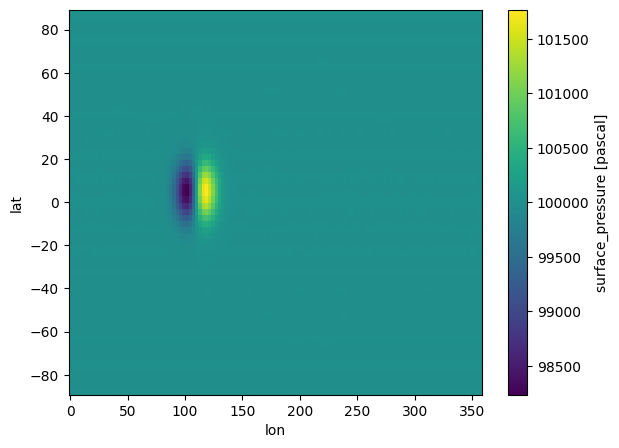

In [7]:
#@test {"skip": true}
#@title Surface Pressure {form-width: "40%"}
pressure_array = initial_state_ds['surface_pressure']
pressure_array_si = dimensionalize(pressure_array, units.pascal)
pressure_array_si.plot.imshow(x='lon', y='lat', size=5)

## Integration of the state in time

In [8]:
# Integration settings
dt_si = 5 * units.minute
save_every = 10 * units.minute
total_time = 24 * units.hour

inner_steps = int(save_every / dt_si)
outer_steps = int(total_time / save_every)
dt = physics_specs.nondimensionalize(dt_si)

# Governing equations
primitive = dinosaur.primitive_equations.PrimitiveEquations(
    ref_temps,
    orography,
    coords,
    physics_specs)

# Implicit/Explicit integrator
integrator = dinosaur.time_integration.imex_rk_sil3
step_fn = integrator(primitive, dt)
filters = [
    dinosaur.time_integration.exponential_step_filter(coords.horizontal, dt)]
step_fn = dinosaur.time_integration.step_with_filters(step_fn, filters)
integrate_fn = jax.jit(dinosaur.time_integration.trajectory_from_step(
    step_fn,
    outer_steps=outer_steps,
    inner_steps=inner_steps,
    start_with_input=True))

# Define trajectory times, expects start_with_input=True
times = save_every * np.arange(0, outer_steps)

In [9]:
# Unrolling trajectory
%time final, trajectory = jax.block_until_ready(integrate_fn(initial_state))

CPU times: user 5.72 s, sys: 750 ms, total: 6.47 s
Wall time: 6.21 s


In [10]:
# Formatting trajectory to xarray.Dataset
def trajectory_to_xarray(coords, trajectory, times):

  trajectory_dict, _ = dinosaur.pytree_utils.as_dict(trajectory)
  u, v = dinosaur.spherical_harmonic.vor_div_to_uv_nodal(
      coords.horizontal, trajectory.vorticity, trajectory.divergence)
  trajectory_dict.update({'u': u, 'v': v})
  nodal_trajectory_fields = dinosaur.coordinate_systems.maybe_to_nodal(
      trajectory_dict, coords=coords)
  trajectory_ds = dinosaur.xarray_utils.data_to_xarray(
      nodal_trajectory_fields, coords=coords, times=times)

  trajectory_ds['surface_pressure'] = np.exp(trajectory_ds.log_surface_pressure[:, 0, :,:])
  temperature = dinosaur.xarray_utils.temperature_variation_to_absolute(
      trajectory_ds.temperature_variation.data, ref_temps)
  trajectory_ds = trajectory_ds.assign(
      temperature=(trajectory_ds.temperature_variation.dims, temperature))

  total_layer_ke = coords.horizontal.integrate(u**2 + v**2)
  total_ke_cumulative = dinosaur.sigma_coordinates.cumulative_sigma_integral(
      total_layer_ke, coords.vertical, axis=-1)
  total_ke = total_ke_cumulative[..., -1]
  trajectory_ds = trajectory_ds.assign(total_kinetic_energy=(('time'), total_ke))
  return trajectory_ds

ds = trajectory_to_xarray(coords, jax.device_get(trajectory), times)

/usr/local/lib/python3.10/dist-packages/xarray/core/indexes.py:190: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  index = pd.Index(np.asarray(array), **kwargs)


## Plot trajectory

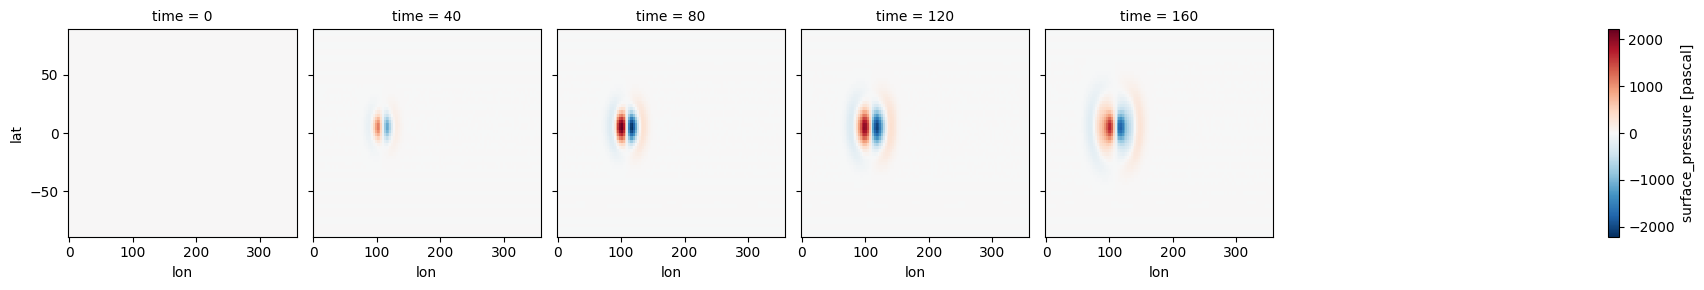

In [11]:
# Surface Pressure Variation
data_array = ds['surface_pressure'] - ds['surface_pressure'].isel(time=0)
data_array_si = dimensionalize(data_array, units.pascal)
data_array_si.isel(time=slice(0, 18, 4)).plot(x='lon', y='lat', col='time', col_wrap=6)

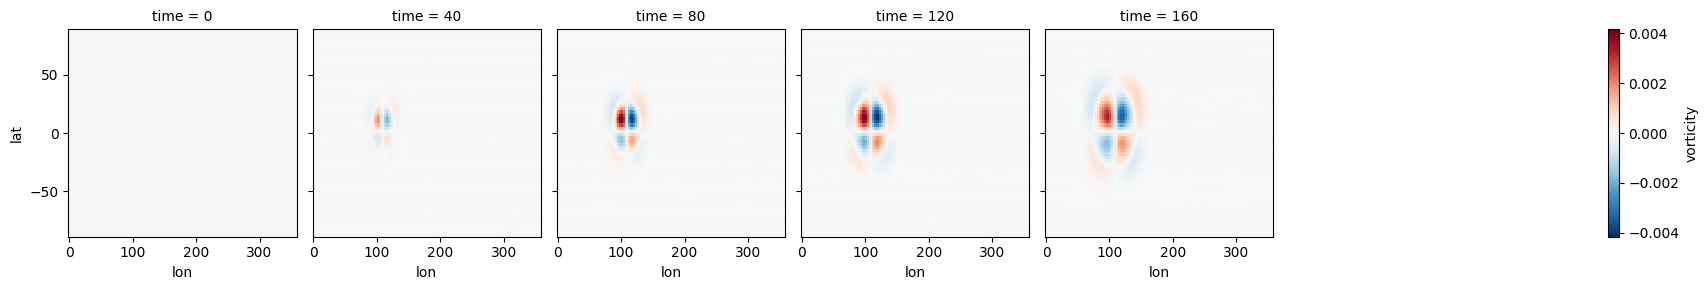

In [12]:
# Vorticity (near earth surface)
data_array = ds['vorticity']
data_array.isel(level=10).isel(time=slice(0, 18, 4)).plot(x='lon', y='lat', col='time', col_wrap=6)

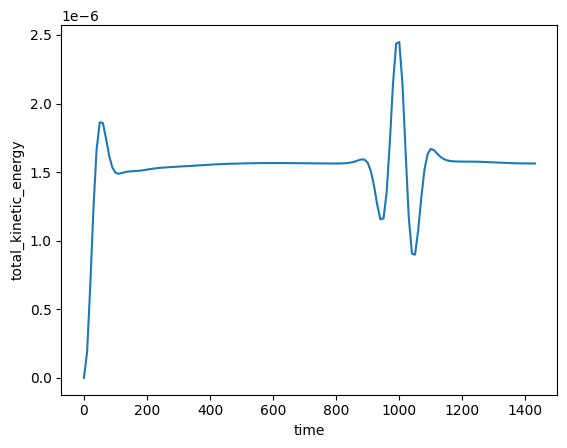

In [13]:
# Total Kinetic Energy
data_array = ds['total_kinetic_energy']
data_array.plot(x='time')
ax = plt.gca()
ax.legend().remove();

# Held-Suarez Forcing

In [14]:
hs = dinosaur.held_suarez.HeldSuarezForcing(
    coords=coords,
    physics_specs=physics_specs,
    reference_temperature=ref_temps,
    p0=p0)

## Plot Held-Suarez coefficients and radiative equilibrium

See Held-Suarez 1994 publication figures for comparison.

In [15]:
def ds_held_suarez_forcing(coords):
  grid = coords.horizontal
  sigma = coords.vertical.centers
  lon, _ = grid.nodal_mesh
  surface_pressure = physics_specs.nondimensionalize(p0) * np.ones_like(lon)
  dims = ('sigma', 'lon', 'lat')
  return xarray.Dataset(
      data_vars={
          'surface_pressure': (('lon', 'lat'), surface_pressure),
          'eq_temp': (dims, hs.equilibrium_temperature(surface_pressure)),
          'kt': (dims, hs.kt()),
          'kv': ('sigma', hs.kv()[:, 0, 0]),
      },
      coords={'lon': grid.nodal_axes[0] * 180 / np.pi,
              'lat': np.arcsin(grid.nodal_axes[1]) * 180 / np.pi,
              'sigma': sigma},
  )

ds = ds_held_suarez_forcing(coords)

def linspace_step(start, stop, step):
  num = round((stop - start) / step) + 1
  return np.linspace(start, stop, num)

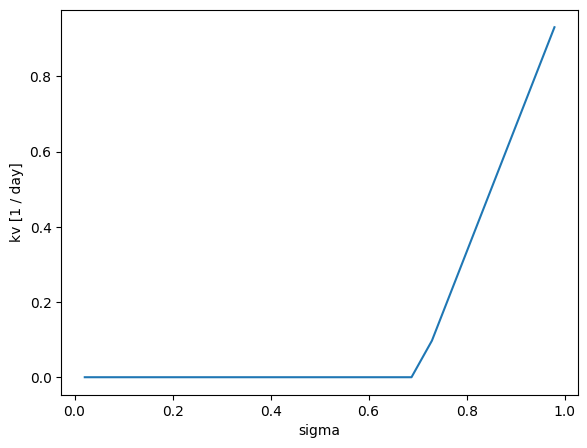

In [16]:
# Friction coefficient {form-width: "40%"}
kv = ds['kv']
kv_si = dimensionalize(kv, 1 / units.day)
kv_si.plot(size=5)

(1.0, 0.0)

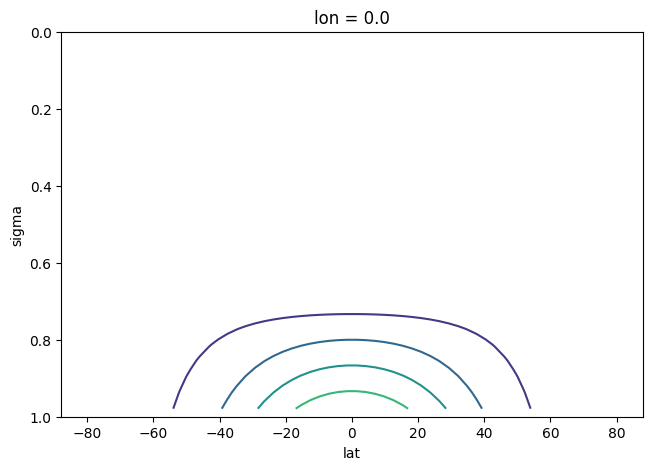

In [17]:
# Thermal relaxation coefficient {form-width: "40%"}
kt_array = ds['kt']
levels = linspace_step(0, 0.3, 0.05)
kt_array_si = dimensionalize(kt_array, 1 / units.day)
p = kt_array_si.isel(lon=0).plot.contour(x='lat', y='sigma', levels=levels,
                                         size=5, aspect=1.5)
ax = plt.gca()
ax.set_ylim((1, 0))
#plt.colorbar(p);

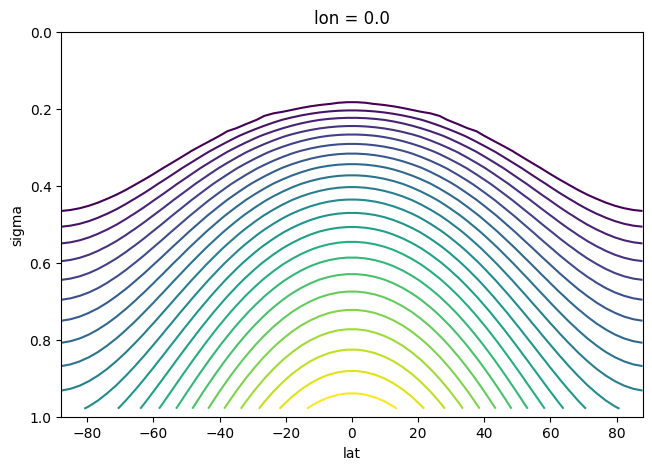

In [18]:
# Radiative equilibrium temperature {form-width: "40%"}
teq_array = ds['eq_temp']
teq_array_si = dimensionalize(teq_array, units.degK)
levels = linspace_step(205, 310, 5)
p = teq_array_si.isel(lon=0).plot.contour(x='lat', y='sigma', levels=levels,
                                          size=5, aspect=1.5)
ax = plt.gca()
ax.set_ylim((1, 0));
#plt.colorbar(p);

<xarray.DataArray ()>
<Quantity(255.083652, 'kelvin')>
<xarray.DataArray ()>
<Quantity(604.483756, 'kelvin')>


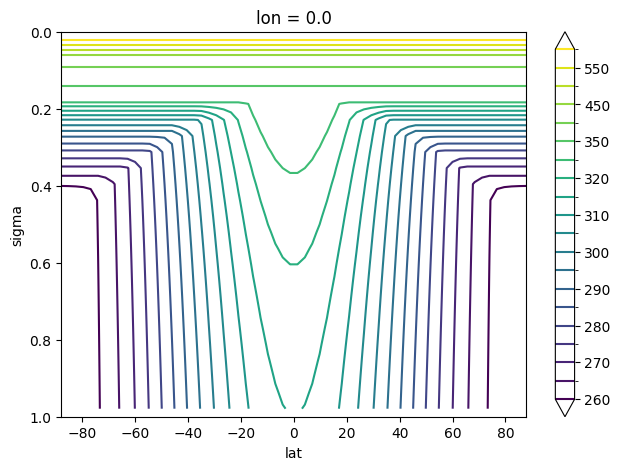

In [19]:
# Radiative equilibrium potential temperature {form-width: "40%"}
temperature = dimensionalize(ds['eq_temp'], units.degK)
surface_pressure = dimensionalize(ds['surface_pressure'], units.pascal)
pressure = ds.sigma * surface_pressure
kappa = dinosaur.scales.KAPPA  # kappa = R / cp, R = gas constant, cp = specific heat capacity
potential_temperature = temperature * (pressure / p0)**-kappa

levels = linspace_step(260, 325, 5)
levels = np.concatenate([levels, np.array([350, 400, 450, 500, 550, 600])], axis=0)
p = potential_temperature.isel(lon=0).plot.contour(x='lat', y='sigma', levels=levels,
                                                   size=5, aspect=1.5)
ax = plt.gca()
ax.set_ylim((1, 0));
plt.colorbar(p)

print(potential_temperature.min())
print(potential_temperature.max())
# Stable for d(potential temperature)/dz > 0

# Integrating with Held-Suarez Forcing

In [20]:
# Integration settings
dt_si = 10 * units.minute
save_every = 10 * units.day
total_time = 1200 * units.day

inner_steps = int(save_every / dt_si)
outer_steps = int(total_time / save_every)
dt = physics_specs.nondimensionalize(dt_si)

# Governing equations
primitive = dinosaur.primitive_equations.PrimitiveEquations(
    ref_temps,
    orography,
    coords,
    physics_specs)

hs_forcing = dinosaur.held_suarez.HeldSuarezForcing(
    coords=coords,
    physics_specs=physics_specs,
    reference_temperature=ref_temps,
    p0=p0)

primitive_with_hs = dinosaur.time_integration.compose_equations([primitive, hs_forcing])


step_fn = dinosaur.time_integration.imex_rk_sil3(primitive_with_hs, dt)
filters = [
    dinosaur.time_integration.exponential_step_filter(
        coords.horizontal, dt, tau=0.0087504, order=1.5, cutoff=0.8),
]

step_fn = dinosaur.time_integration.step_with_filters(step_fn, filters)
integrate_fn = jax.jit(dinosaur.time_integration.trajectory_from_step(
    step_fn,
    outer_steps=outer_steps,
    inner_steps=inner_steps))

# Define trajectory times, expects start_with_input=False
times = save_every * np.arange(1, outer_steps+1)

In [21]:
%time final, trajectory = jax.block_until_ready(integrate_fn(initial_state))

CPU times: user 3min 42s, sys: 4min 2s, total: 7min 44s
Wall time: 8min 1s


In [22]:
ds = trajectory_to_xarray(coords, jax.device_get(trajectory), times)

/usr/local/lib/python3.10/dist-packages/xarray/core/indexes.py:190: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  index = pd.Index(np.asarray(array), **kwargs)


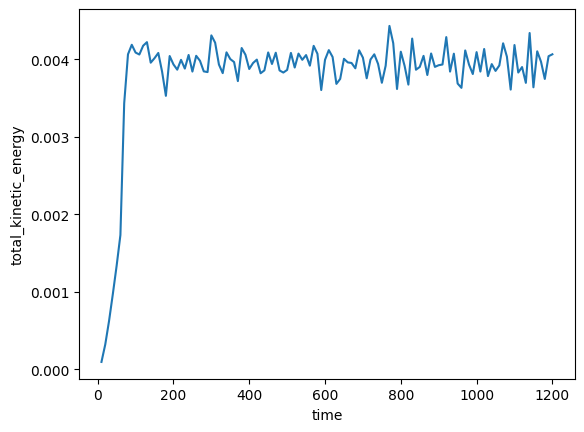

In [23]:
# Total Kinetic Energy
data_array = ds['total_kinetic_energy']
# data_array = dimensionalize(data_array, units.degK)
data_array.plot(x='time')
ax = plt.gca()
ax.legend().remove();

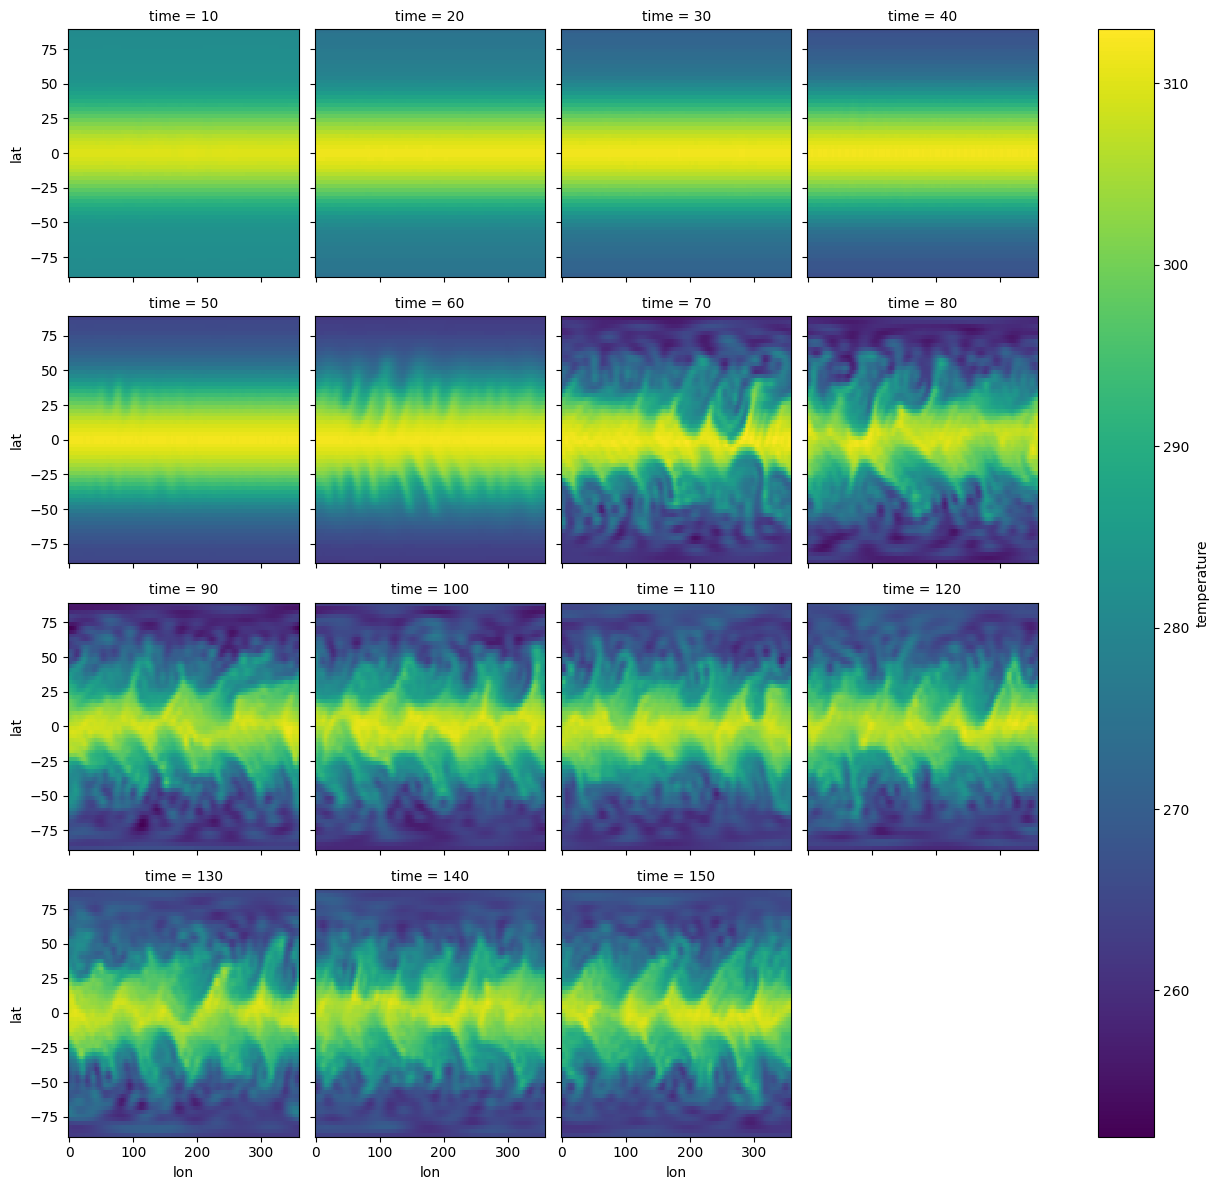

In [24]:
# Temperature
mask = ds['time'] <= 150  # days
data_array = ds['temperature']
data_array.isel(level=-1, time=mask).plot(
    x='lon', y='lat', col='time', col_wrap=4)

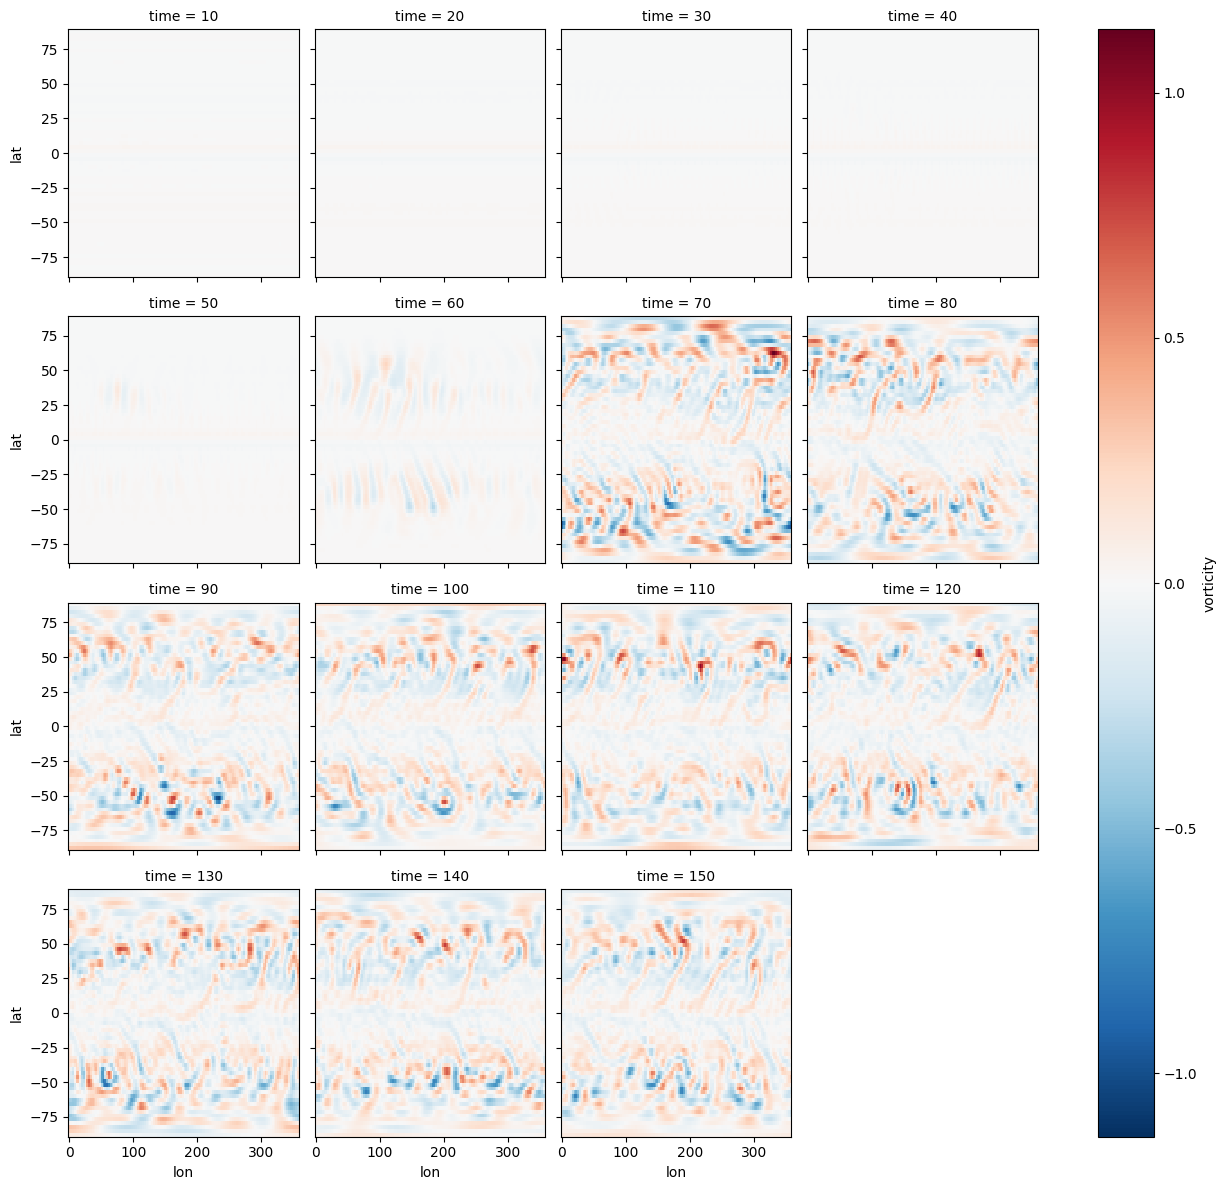

In [25]:
# Vorticity
mask = ds['time'] <= 150  # days
data_array = ds['vorticity']
data_array.isel(level=-1, time=mask).plot(
    x='lon', y='lat', col='time', col_wrap=4)

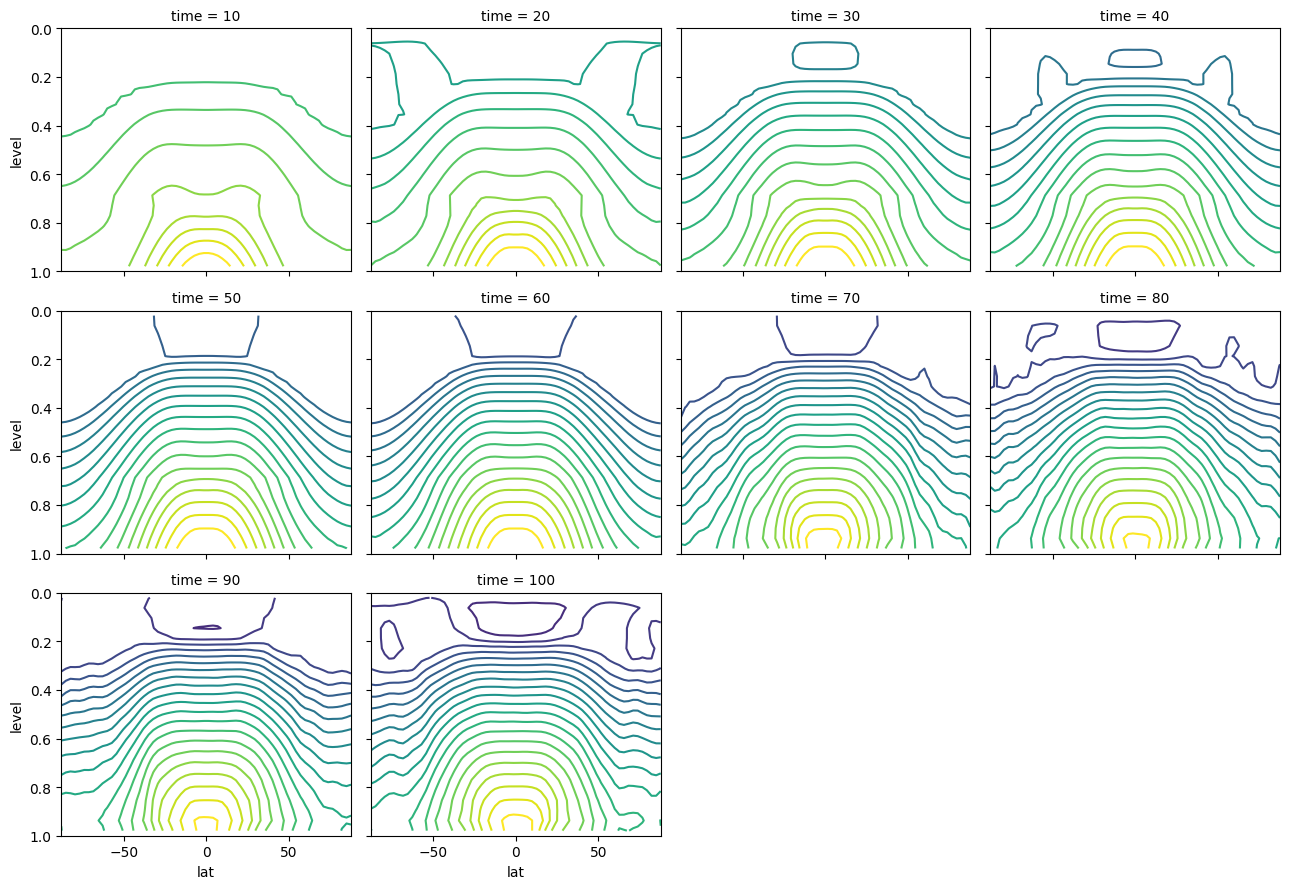

In [26]:
# Temperature
mask = ds['time'] <= 100  # days
data_array = ds['temperature']
data_array = dimensionalize(data_array, units.degK)
levels = linspace_step(190, 305, 5)
data_array.isel(time=mask).mean('lon').plot.contour(
    x='lat', y='level', col='time', col_wrap=4, levels=levels)
ax = plt.gca()
ax.set_ylim((1, 0));

## Plots for `time > start_time`, averaged over time and longitude

In [27]:
start_time = 200 # days

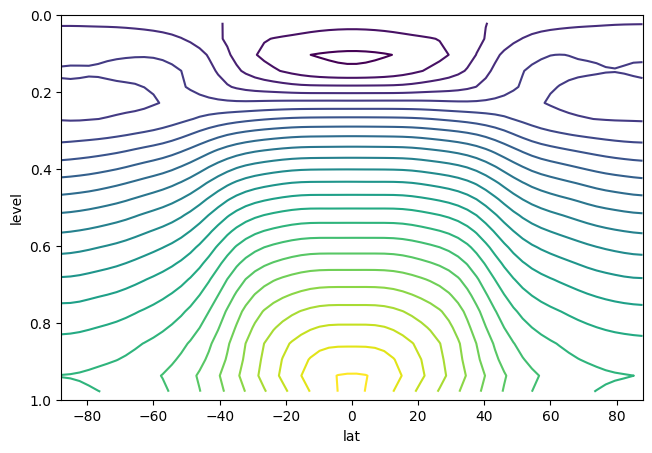

In [28]:
# Mean Temperature
mask = ds['time'] > start_time
data_array = ds['temperature']
data_array = dimensionalize(data_array, units.degK)
levels = linspace_step(190, 305, 5)
data_array.isel(time=mask).mean(['lon', 'time']).plot.contour(
    x='lat', y='level', levels=levels, size=5, aspect=1.5)
ax = plt.gca()
ax.set_ylim((1, 0));

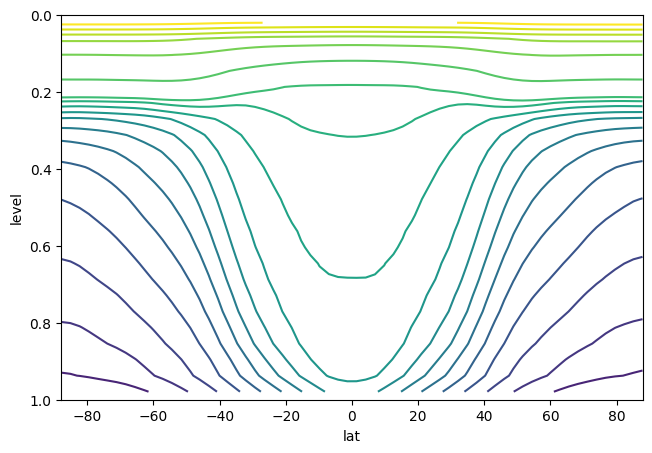

In [29]:
# Mean Potential Temperature
mask = ds['time'] > start_time  # start with day=84 (12 weeks)
temperature = dimensionalize(ds['temperature'], units.degK)
surface_pressure = dimensionalize(ds['surface_pressure'], units.pascal)
pressure = ds.level * surface_pressure
kappa = dinosaur.scales.KAPPA  # kappa = R / cp, R = gas constant, cp = specific heat capacity
potential_temperature = temperature * (pressure / p0)**-kappa

levels = linspace_step(260, 325, 5)
levels = np.concatenate([levels, np.array([350, 400, 450, 500, 550, 600])], axis=0)
p = potential_temperature.isel(time=mask).mean(['lon', 'time']).plot.contour(
    x='lat', y='level', levels=levels, size=5, aspect=1.5)
ax = plt.gca()
ax.set_ylim((1, 0));

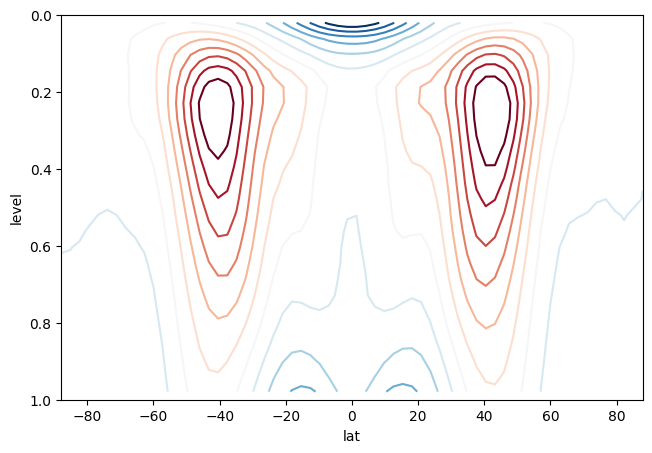

In [30]:
# Zonal Mean Wind
mask = ds['time'] > start_time
data_array = ds['u']
data_array = dimensionalize(data_array, units.meter / units.s)
levels = linspace_step(-20, 28, 4)
data_array.isel(time=mask).mean(['lon', 'time']).plot.contour(
    x='lat', y='level', levels=levels, size=5, aspect=1.5)
ax = plt.gca()
ax.set_ylim((1, 0));

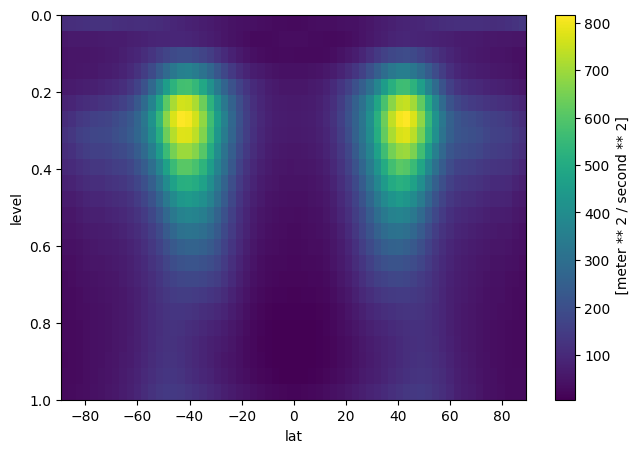

In [31]:
# Eddy kinetic energy {form-width: "40%"}
mask = ds['time'] > start_time
data_array = ds['u']

data_array2 = ds['v']
data_array = dimensionalize(data_array, units.meter / units.s)
data_array2 = dimensionalize(data_array2, units.meter / units.s)

mean_u = data_array.isel(time=mask).mean(['time'])
zonal_u = data_array.isel(time=mask)

mean_v = data_array2.isel(time=mask).mean(['time'])
zonal_v = data_array2.isel(time=mask)


eke = (zonal_u - mean_u)**2 + (zonal_v - mean_v)**2
# levels = linspace_step(5, 45, 5)
#levels = 30
p = eke.mean(['time', 'lon']).plot(
    x='lat', y='level', size=5, aspect=1.5)
ax = plt.gca()
ax.set_ylim((1, 0));
# plt.colorbar(p)

## Visualizing steady state dynamics after 1200 Days

In [32]:
# Integration settings
dt_si = 10 * units.minute
save_every = 6 * units.hours
total_time = 1 * units.week

inner_steps = int(save_every / dt_si)
outer_steps = int(total_time / save_every)
dt = physics_specs.nondimensionalize(dt_si)

# Leapfrog integrator
step_fn = dinosaur.time_integration.imex_rk_sil3(primitive_with_hs, dt)
filters = [
    dinosaur.time_integration.exponential_step_filter(
        coords.horizontal, dt, tau=0.0087504, order=1.5, cutoff=0.8),
]
step_fn = dinosaur.time_integration.step_with_filters(step_fn, filters)
integrate_fn = jax.jit(dinosaur.time_integration.trajectory_from_step(
    step_fn,
    outer_steps=outer_steps,
    inner_steps=inner_steps,
))

times = save_every * np.arange(1, outer_steps+1)

In [33]:
%time final_2, trajectory_2 = jax.block_until_ready(integrate_fn(final))

CPU times: user 6.71 s, sys: 1.7 s, total: 8.42 s
Wall time: 8.02 s


In [34]:
ds = trajectory_to_xarray(coords, trajectory_2, times)

/usr/local/lib/python3.10/dist-packages/xarray/core/indexes.py:190: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  index = pd.Index(np.asarray(array), **kwargs)


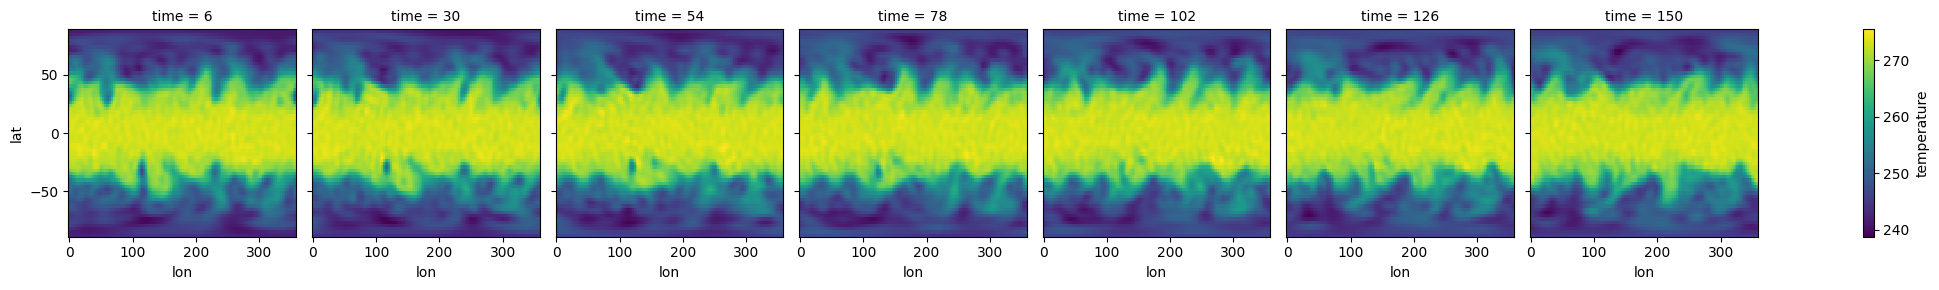

In [35]:
# Temperature
data_array = ds['temperature']
data_array.thin(time=4).isel(level=-10).plot(x='lon', y='lat', col='time')

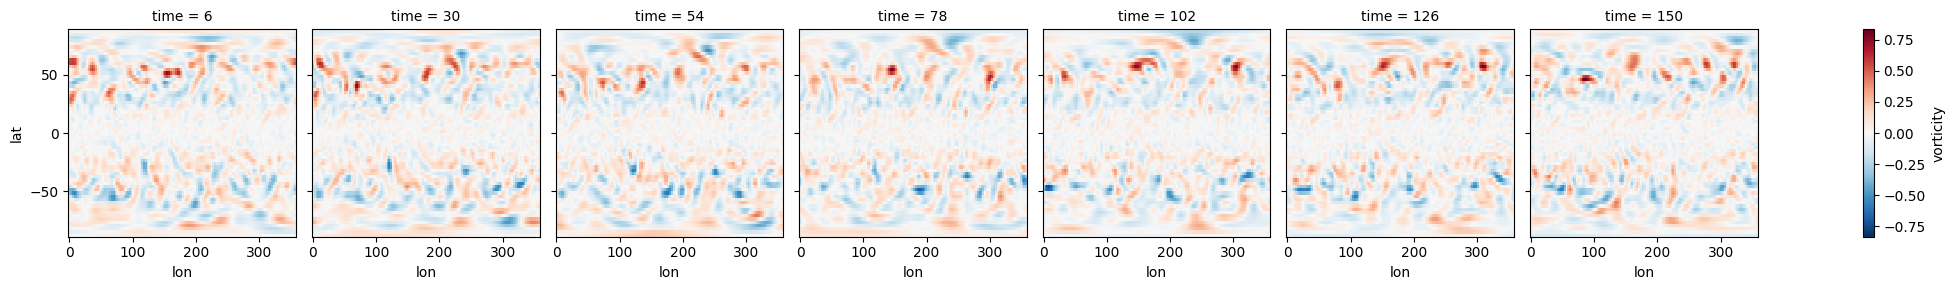

In [36]:
# Vorticity
data_array = ds['vorticity']
data_array.thin(time=4).isel(level=-5).plot(x='lon', y='lat', col='time')